In [1]:
#update the cell fraction function
import scanpy as sc #for scanpy >= 1.3.7
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import logging
import os
import glob
import matplotlib
import math

In [23]:
savepath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/processed_data/annotated_final.h5ad'
adata = sc.read_h5ad(savepath)

In [24]:
adata.obs.GeneralAnnotation.unique()

['CD3+', 'NK', 'Doublets', 'Proliferating', 'Macrophage', ..., 'Plasma', 'DC', 'LSECs', 'Monocyte', 'Platelets']
Length: 12
Categories (12, object): ['B-cell', 'CD3+', 'DC', 'Doublets', ..., 'Plasma', 'Platelets', 'Proliferating', 'unknown']

In [ ]:
#make a temporal modification of name of NK subtypes

In [25]:
adata.obs['FinalAnnotation'] = adata.obs['FinalAnnotation'].astype('object')
adata.obs['subtype_final'] = adata.obs['subtype_final'].astype('object')

In [27]:
adata.obs.loc[adata.obs.FinalAnnotation == 'NK', 'FinalAnnotation'] = 'NK_CD16+CD56dim'
adata.obs.loc[adata.obs.FinalAnnotation == 'NK-Resident', 'FinalAnnotation'] = 'NK_CD16-CD56bright'

In [28]:
adata.obs.loc[adata.obs.subtype_final == 'NK', 'subtype_final'] = 'NK_CD16+CD56dim'
adata.obs.loc[adata.obs.subtype_final == 'NK-Resident', 'subtype_final'] = 'NK_CD16-CD56bright'

In [33]:
def cell_frac(adata, cell_type, tissue):
    ind = adata.obs.loc[(adata.obs.GeneralAnnotation == cell_type) & 
                        (adata.obs.tissue == tissue)].index
    temp = adata[ind,:].copy()

    
    df = temp.obs.groupby(['subtype_final','patient_id'], observed=False).size().unstack()
    df = df.transpose()
    df['cell_total_number'] = df.sum(axis = 1)
    n_subtype = len(temp.obs['subtype_final'].unique())
    for c in df.iloc[:,0:n_subtype].columns:
        name = c + ' frac'
        df[name] = df[c] / df['cell_total_number']

    for group in temp.obs['Group'].unique():
        for ID in temp.obs.loc[temp.obs['Group'] == group, 'patient_id'].unique():
            df.loc[ID, 'group'] = group
            
    
    df.group = pd.Categorical(df.group, 
                      categories=['HC', 'IT', 'IA', 'AR', 'CR'],
                      ordered=True)
    
    df = df.sort_values(by = ['group'])
    
    
    
    return(df)

def scatterplot(df, group, celltype, palette,
                title, ylabel, path, name, fig_format, save = True):
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 16
    rcParams['figure.figsize'] = (4,7)
    rcParams["savefig.format"] = fig_format
    
    
    fig, ax1 = plt.subplots(1,1)
    
    sb.scatterplot(x=group, y=celltype, hue = group, palette = palette, data=df, 
                   s = 300, alpha = 0.9, marker="$\circ$", ec="face", ax=ax1)
    
    PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'}
    }
    sb.boxplot(x=group,y=celltype,
            data=df,
            showfliers=False,
            linewidth=1.5, 
            **PROPS, ax = ax1)
    
    ymax = df.loc[:,celltype].max()
    group_list = list(df.group.cat.categories)
    ylim = [-0.01, ymax + 0.5]
    xlim = [-0.5, len(group_list)-0.5]

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_title(title)
    ax1.set_xlabel("")
    ax1.set_ylabel(ylabel)

    ax1.legend(title = 'Group', bbox_to_anchor=(1.5, 1))
    
    #calculate p_value
    dic_p = wilcox_cal(df, celltype)
    #plot p_value if dic_p is not empty
    if len(dic_p.keys()) != 0:
        p_value_plot(ax1, dic_p, group_list, ymax)
    
    
    if save == True:
        save_dir = os.path.join(path, name)
        fig.savefig(save_dir, bbox_inches='tight')

def scatter_batch(df, group, pool, celltype_list, palette,
                path, fig_format, save = True):
    for celltype in celltype_list:
        title = celltype
        celltype_frac = celltype+' frac'
        ylabel = "Percentage in {}".format(pool)
        name = celltype.split('/')[0]
        scatterplot(df,'group', celltype_frac,palette, 
            title, ylabel,figpath, name, fig_format = fig_format, save = True)        
        
        
def p_value_plot(ax, dic,group_list, ymax):
    for key in dic.keys():
        param = {}

        first_group_loc = group_list.index(dic[key]['pair'][0])
        second_group_loc = group_list.index(dic[key]['pair'][1])
        
        param['arrow_x'] = first_group_loc - 0.2
        param['arrow_y'] = ymax + 0.05 + 0.1*key
        param['arrow_lenth'] = second_group_loc - first_group_loc + 0.5
        param['text_x'] = (second_group_loc - first_group_loc)/2-0.6 + first_group_loc 
        param['text_y'] = param['arrow_y'] + 0.02
        param['text'] = 'p = {}'.format(dic[key]['p_value'])
        
        ax.arrow(param['arrow_x'],
                 param['arrow_y'], 
                 param['arrow_lenth'],
                 0,head_length=0.0,head_width=0.0, width = 0.001)
        
        ax.text(param['text_x'], 
                param['text_y'], 
                param['text'], 
                fontsize = 16)
        
from scipy.stats import mannwhitneyu
def wilcox_cal(df, celltype_frac):
    dic = {}
    n = 0
    group_list = list(df.group.cat.categories)
    for i, group_1 in enumerate(group_list):
        if i < len(group_list):
            for j in np.arange(i+1, len(group_list)):
                if i < j:
                    group_2 = group_list[j]
                    group_1_data = df.loc[df.group == group_1, celltype_frac]
                    group_2_data = df.loc[df.group == group_2, celltype_frac]
                    if group_1_data.mean() <= group_2_data.mean():
                        U1, p = mannwhitneyu(group_1_data, group_2_data, 
                                             method="exact", alternative = 'less')
                    else:
                        U1, p = mannwhitneyu(group_2_data, group_1_data, 
                                             method="exact", alternative = 'less')

                    if p < 0.05:
                        temp_dic = {}
                        temp_dic['pair'] = [group_1, group_2]
                        temp_dic['p_value'] = round(p,3)
                        dic[n] = temp_dic
                        n = n + 1
    return(dic)        
        
def p_value_table_gen(df):
    dic = {}
    n = 0
    group_list = list(df.group.cat.categories)
    df_temp = pd.DataFrame(columns = ['celltype', 'group1', 'group2', 'p_value', 'significance','tissue'])
    
    celltype_frac_list = [x for x in df.columns if x not in ['tissue', 'group']]
    for celltype_frac in celltype_frac_list:
        for i, group_1 in enumerate(group_list):
            if i < len(group_list):
                for j in np.arange(i+1, len(group_list)):
                    if i < j:
                        group_2 = group_list[j]
                        group_1_data = df.loc[df.group == group_1, celltype_frac]
                        group_2_data = df.loc[df.group == group_2, celltype_frac]
                        if group_1_data.mean() <= group_2_data.mean():
                            U1, p = mannwhitneyu(group_1_data, group_2_data, 
                                                 method="exact", alternative = 'less')
                        else:
                            U1, p = mannwhitneyu(group_2_data, group_1_data, 
                                                 method="exact", alternative = 'less')


                        df_temp.loc[n, 'celltype'] = celltype_frac.split(' frac')[0]
                        df_temp.loc[n, 'group1'] = group_1
                        df_temp.loc[n, 'group2'] = group_2
                        df_temp.loc[n, 'p_value'] = p
                        df_temp.loc[n, 'tissue'] = df.tissue.unique()[0]
                        
                        if p < 0.05:
                            df_temp.loc[n, 'significance'] = 'true'
                        else:
                            df_temp.loc[n, 'significance'] = 'false'
                        
                        n = n + 1
    
    root_path = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/table'
    name = df.tissue.unique()[0]+'.tsv'
    path = os.path.join(root_path,name)
    df_temp.to_csv(path, sep = '\t')
    
    return(df_temp)        
    
    

In [30]:
#for liver
cell_type = 'NK'
tissue  = 'Liver'
df = cell_frac(adata, cell_type, tissue)

In [31]:
df

subtype_final,NK_CD16+CD56dim,NK_CD16-CD56bright,cell_total_number,NK_CD16+CD56dim frac,NK_CD16-CD56bright frac,group
patient_id,,,,,,
D528848,852,704,1556,0.547558,0.452442,HC
D529074,818,539,1357,0.602800,0.397200,HC
D529351,556,505,1061,0.524034,0.475966,HC
D529354,364,543,907,0.401323,0.598677,HC
D529409,849,386,1235,0.687449,0.312551,HC
Dhc570,1516,579,2095,0.723628,0.276372,HC
P190326,453,229,682,0.664223,0.335777,IT
P190402,560,805,1365,0.410256,0.589744,IT
P190604,525,208,733,0.716235,0.283765,IT


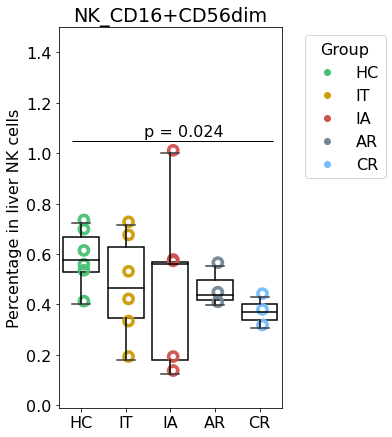

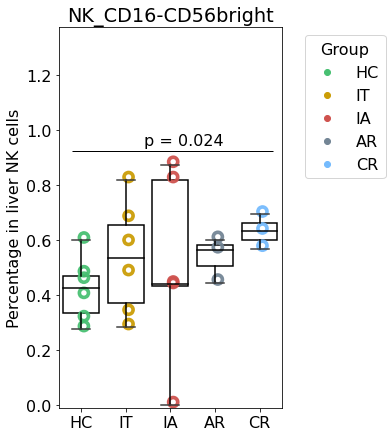

In [34]:
#for NK in liver
cell_type = 'NK'
tissue  = 'Liver'
df = cell_frac(adata, cell_type, tissue)
fig_format = 'png'


figpath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/NK_cells/Liver'
palette = ['#48c072', '#cb9d06', '#cf524e', '#738595', '#75bbfd']
pool = 'liver NK cells'
celltype_list = list(adata.obs.loc[adata.obs.GeneralAnnotation == cell_type].subtype_final.unique())


scatter_batch(df, 'group', pool, celltype_list, palette,
                figpath, fig_format = fig_format, save = True)

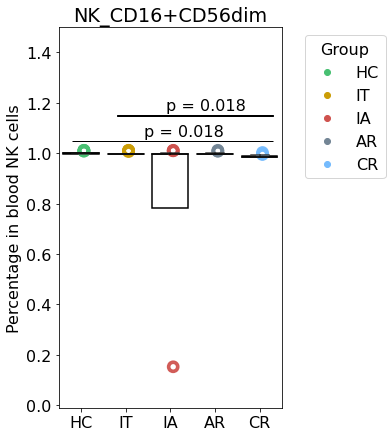

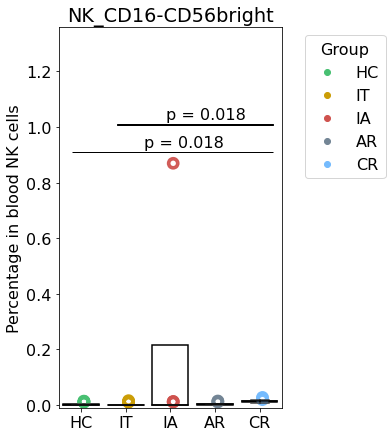

In [46]:
#for NK in Blood
cell_type = 'NK'
tissue  = 'Blood'
df = cell_frac(adata, cell_type, tissue)
fig_format = 'png'


figpath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/NK_cells/Blood'
palette = ['#48c072', '#cb9d06', '#cf524e', '#738595', '#75bbfd']
pool = 'blood NK cells'
celltype_list = list(adata.obs.loc[adata.obs.GeneralAnnotation == cell_type].subtype_final.unique())


scatter_batch(df, 'group', pool, celltype_list, palette,
                figpath, fig_format = fig_format, save = True)

In [37]:
df

subtype_final,NK_CD16+CD56dim,NK_CD16-CD56bright,cell_total_number,NK_CD16+CD56dim frac,NK_CD16-CD56bright frac,group
patient_id,,,,,,
D528848,2988,10,2998,0.996664,0.003336,HC
D529074,2890,1,2891,0.999654,0.000346,HC
D529351,776,2,778,0.997429,0.002571,HC
D529354,546,0,546,1.000000,0.000000,HC
D529409,1362,1,1363,0.999266,0.000734,HC
P190910,1904,3,1907,0.998427,0.001573,IT
P190902,775,4,779,0.994865,0.005135,IT
P190808,981,1,982,0.998982,0.001018,IT
P190604,1336,0,1336,1.000000,0.000000,IT


In [40]:
#try remove patient P190719 as it is an outliner
adata_2 = adata[adata.obs.patient_id != 'P190719']

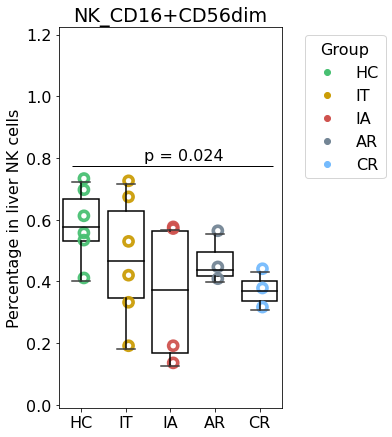

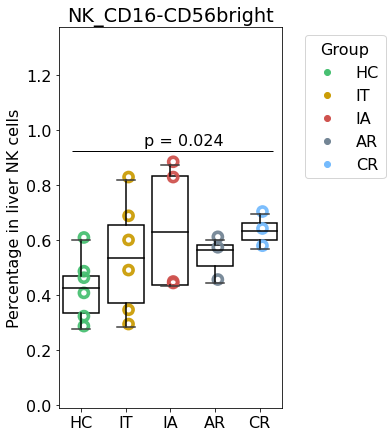

In [44]:
#for NK in liver
cell_type = 'NK'
tissue  = 'Liver'
df = cell_frac(adata_2, cell_type, tissue)
fig_format = 'png'


figpath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/NK_cells/Liver/no_P190719'
palette = ['#48c072', '#cb9d06', '#cf524e', '#738595', '#75bbfd']
pool = 'liver NK cells'
celltype_list = list(adata_2.obs.loc[adata_2.obs.GeneralAnnotation == cell_type].subtype_final.unique())


scatter_batch(df, 'group', pool, celltype_list, palette,
                figpath, fig_format = fig_format, save = True)

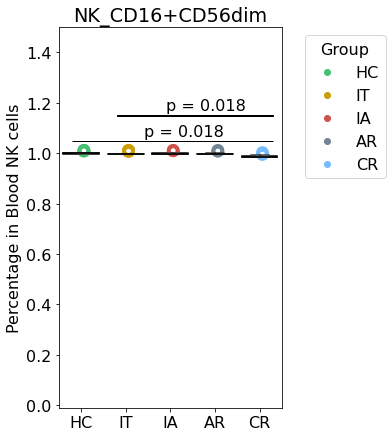

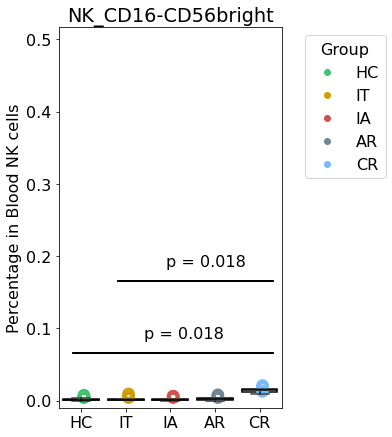

In [45]:
#for NK in blood
cell_type = 'NK'
tissue  = 'Blood'
df = cell_frac(adata_2, cell_type, tissue)
fig_format = 'png'


figpath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/NK_cells/Blood/no_P190719'
palette = ['#48c072', '#cb9d06', '#cf524e', '#738595', '#75bbfd']
pool = 'Blood NK cells'
celltype_list = list(adata_2.obs.loc[adata_2.obs.GeneralAnnotation == cell_type].subtype_final.unique())


scatter_batch(df, 'group', pool, celltype_list, palette,
                figpath, fig_format = fig_format, save = True)